In [31]:
#Import des libairies
import scipy
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import scipy.io.wavfile
import IPython.display as ipd

from torch.utils.data import Dataset,DataLoader, random_split

import pytorch_lightning as pl

from pytorch_lightning.loggers import TensorBoardLogger

import subprocess
import time

from datetime import datetime

from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor


import torch.nn.functional as F


In [45]:
torch.cuda.empty_cache()

# Analyse des datas

In [6]:
#Foncion pour lire les 3 fichiers audio
def read_audio_folder(numero_fichier="0000",chemin_fichier=r"data_source_separation\train_small\train_small"):
    chemin = chemin_fichier + "\\" + numero_fichier
    
    for fichier in os.listdir(chemin):
        chemin_fichier = chemin + "\\" + fichier
        if "mix" in fichier:
            frequence_mix, signal_mix = scipy.io.wavfile.read(chemin_fichier)
        elif "noise" in fichier:
            frequence_noise, signal_noise = scipy.io.wavfile.read(chemin_fichier)
        elif "voice" in fichier:
            frequence_voice, signal_voice = scipy.io.wavfile.read(chemin_fichier)
        else:
            print("Fichier non reconnu")
    if frequence_mix != frequence_noise or frequence_mix != frequence_voice:
        assert False, "Les fréquences des fichiers ne sont pas les mêmes"
    return {"frequence_mix":frequence_mix, "signal_mix":signal_mix, "frequence_noise":frequence_noise, "signal_noise":signal_noise, "frequence_voice":frequence_voice, "signal_voice":signal_voice}


def plot_audio_folder(numero_fichier="0000",chemin_fichier=r"data_source_separation\train_small\train_small"):
    #Read one audio file
    audio = read_audio_folder(numero_fichier,chemin_fichier)

    type_fichier = (
    "train" if "train" in chemin_fichier 
    else "test" if "test" in chemin_fichier 
    else "train_small" if "train_small" in chemin_fichier 
    else "unknown"
)

    # Visualiser les fichiers audio
    figure, axes = plt.subplots(1, 4, figsize=(20, 6))
    figure.suptitle(f"Signaux du fichier {numero_fichier} de type {type_fichier}")
    # Signal mix
    axes[0].plot(audio["signal_mix"])
    axes[0].set_title("Signal mix")
    ipd.display(ipd.Audio(data=audio["signal_mix"], rate=audio["frequence_mix"]))
    sns.despine()

    # Signal noise
    axes[1].plot(audio["signal_noise"])
    axes[1].set_title("Signal noise")
    ipd.display(ipd.Audio(data=audio["signal_noise"], rate=audio["frequence_noise"]))
    sns.despine()

    # Signal voice
    axes[2].plot(audio["signal_voice"])
    axes[2].set_title("Signal voice")
    ipd.display(ipd.Audio(data=audio["signal_voice"], rate=audio["frequence_voice"]))
    sns.despine()

    #Le tout
    axes[3].plot(audio["signal_mix"], label="mix", alpha=0.5)
    axes[3].plot(audio["signal_noise"], label="noise", alpha=0.5)
    axes[3].plot(audio["signal_voice"], label="voice", alpha=0.5)
    axes[3].legend()
    axes[3].set_title("Superposition des signaux")
    sns.despine()


    plt.show()
    



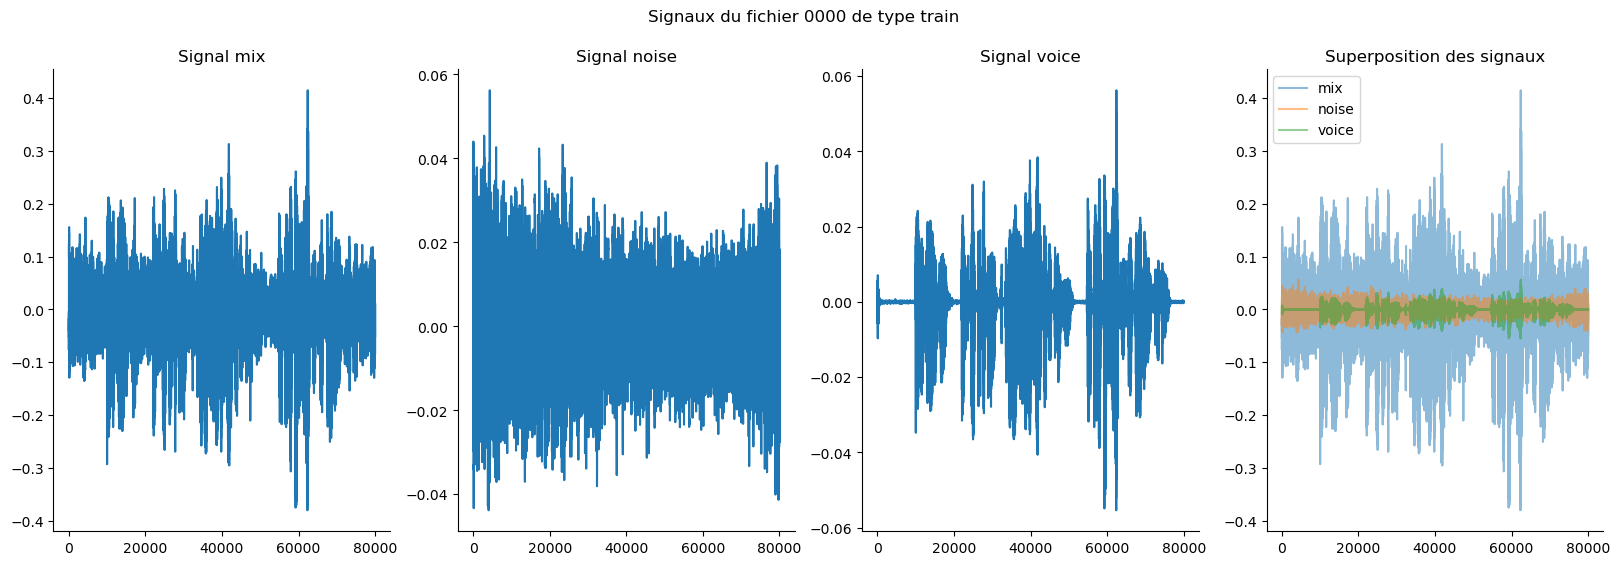

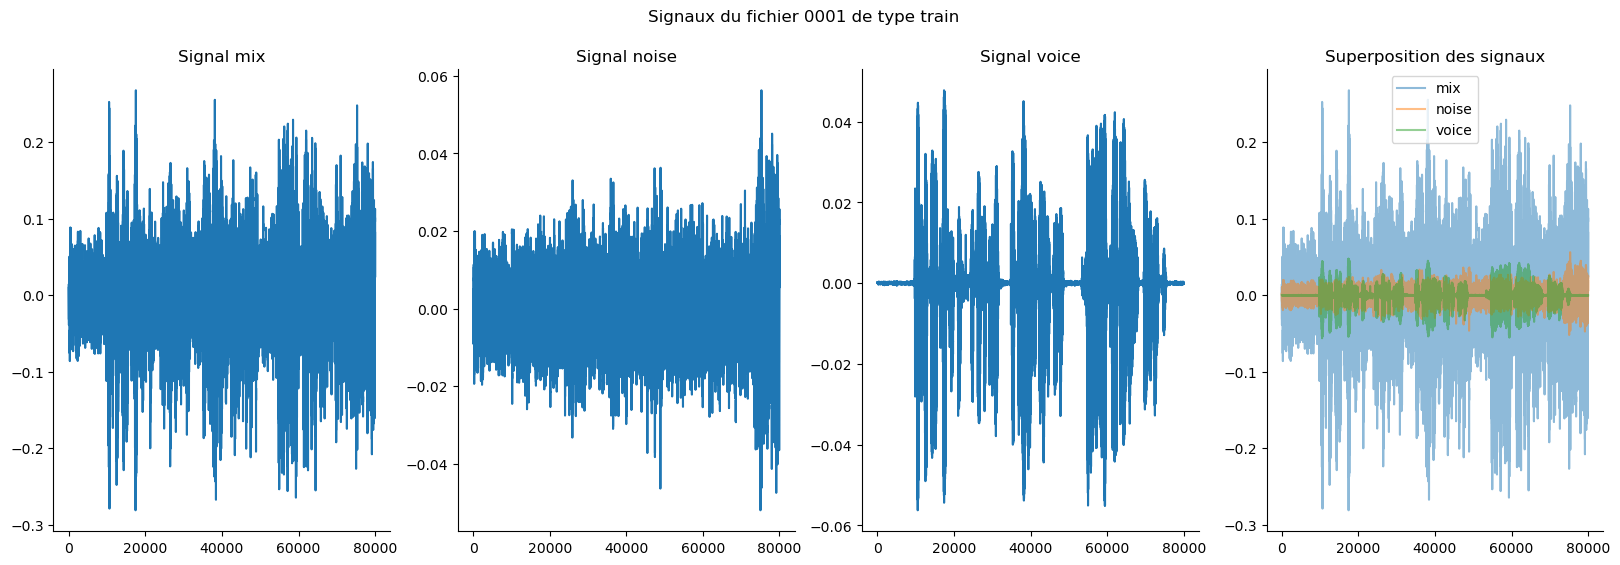

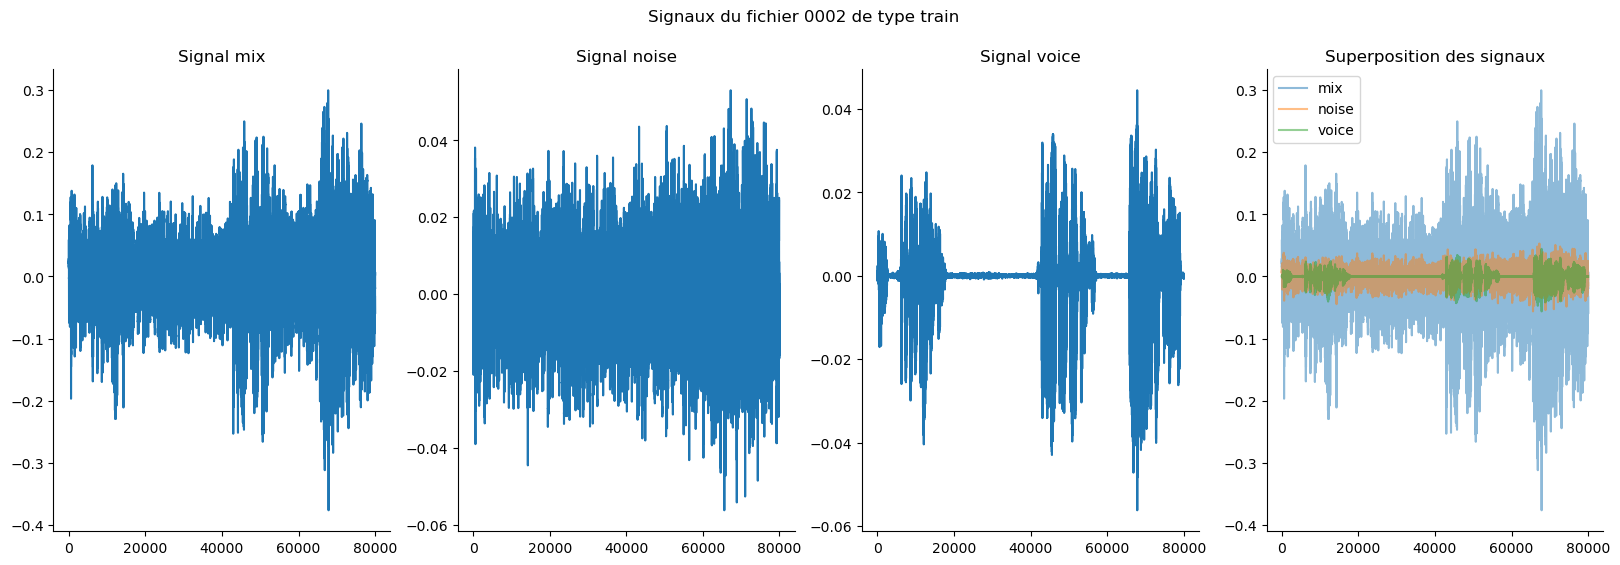

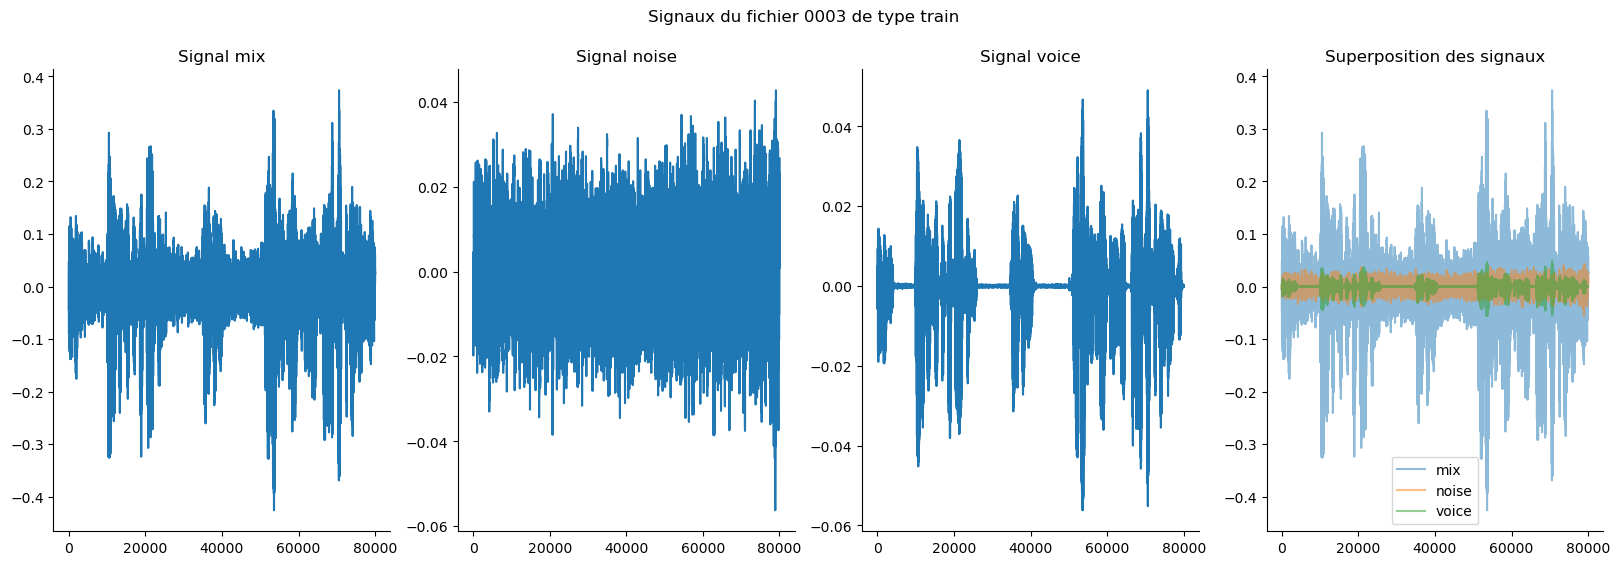

In [7]:
for i in range(4):
    plot_audio_folder(numero_fichier=f"{i:04d}")

# On définit les fonctions

In [8]:
max_epochs = 100

In [9]:
class Dataset_audio(Dataset):
    
    def __init__(self,data_dir):
        self.data_dir = data_dir
        self.names =[name_folder for name_folder in os.listdir(data_dir)]

        
    def __len__(self): # retourne le nombre de données dans le dataset
        return len(self.names)
    
    def __getitem__(self, i):
        audio = read_audio_folder(numero_fichier=self.names[i],chemin_fichier=self.data_dir)

        signal_mix_i = torch.tensor(audio["signal_mix"], dtype=torch.float32).unsqueeze(0)
        signal_noise_i = torch.tensor(audio["signal_noise"], dtype=torch.float32).unsqueeze(0)
        signal_voice_i = torch.tensor(audio["signal_voice"], dtype=torch.float32).unsqueeze(0)
        frequence_i = torch.tensor(audio["frequence_mix"], dtype=torch.long)

        return signal_mix_i, signal_noise_i, signal_voice_i,frequence_i

In [10]:
data = Dataset_audio(data_dir=r"data_source_separation\train_small\train_small")
print(len(data))
print(data[0][0].shape)
print(data[0][1].shape)
print(data[0][2].shape)
print(data[0][3].shape) 

50
torch.Size([1, 80000])
torch.Size([1, 80000])
torch.Size([1, 80000])
torch.Size([])


In [41]:
class AudioDataModule(pl.LightningDataModule):
    def __init__(self,train_dir,test_dir,batch_size=4,val_split=0.2,):
        super().__init__()
        self.train_dir = train_dir
        self.test_dir = test_dir
        self.batch_size = batch_size
        self.val_split = val_split

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.predict_dataset = None


    def setup(self, stage=None):
        if stage == "fit":
            full_dataset = Dataset_audio(data_dir=self.train_dir)

            total_size = len(full_dataset)
            val_size = int(total_size * self.val_split)
            train_size = total_size - val_size

            self.train_dataset, self.val_dataset = random_split(
                full_dataset,
                [train_size, val_size],
                generator=torch.Generator().manual_seed(10))

        elif stage == "test":
            self.test_dataset = Dataset_audio(data_dir=self.test_dir)

        elif stage == "predict":
            self.predict_dataset = Dataset_audio(data_dir=self.predict_dir)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dir,
            batch_size=self.batch_size,
            shuffle=False,
        )

    def predict_dataloader(self):
        return DataLoader(
            self.predict_dataset,
            batch_size=self.batch_size,
            shuffle=False,
        )

In [47]:
batch_size = 1
datamodule = AudioDataModule(train_dir=r"data_source_separation\train\train", test_dir=r"data_source_separation\test", batch_size=batch_size, val_split=0.2)

In [65]:
#from model.waveunet import Waveunet
#from pytorch_lightning import Trainer
#from pytorch_lightning.callbacks import ModelCheckpoint


In [14]:
class UNetAudio(nn.Module):
    def __init__(self, input_channels=1, output_channels=2):
        super(UNetAudio, self).__init__()
        # Exemple simple de U-Net avec deux sorties (voix et bruit)
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.middle = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv1d(64, output_channels, kernel_size=3, padding=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x  # Sorties : [B, 2, T] (voix et bruit)


In [59]:
class JointLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(JointLoss, self).__init__()
        self.alpha = alpha
        self.l1_loss = nn.L1Loss()

    def forward(self, prediction_voice, signal_voice, prediction_noise, signal_noise):
        # Perte pour la composante voix
        voice_loss = self.l1_loss(prediction_voice, signal_voice)
        
        # Perte pour la composante bruit
        noise_loss = self.l1_loss(prediction_noise, signal_noise)
        
        # Total loss (pondérée)
        total_loss = self.alpha * voice_loss + (1 - self.alpha) * noise_loss
        return total_loss

class Custom_MSEloss(nn.Module):
    def __init__(self):
        super(Custom_MSEloss, self).__init__()
        self.mse_loss = nn.MSELoss()

    def forward(self, prediction_voice, signal_voice, prediction_noise, signal_noise):
        # Combine voix et bruit pour une MSE globale
        combined_predictions = torch.cat([prediction_voice, prediction_noise], dim=1)
        combined_targets = torch.cat([signal_voice, signal_noise], dim=1)
        return self.mse_loss(combined_predictions, combined_targets)

In [16]:
# import matplotlib.pyplot as plt
# import io
# from PIL import Image

# def plot_signals(signal_mix, signal_voice, signal_noise, prediction_voice, prediction_noise, batch_idx):
#     """
#     Crée un graphique avec les signaux pour le premier batch.
#     """
#     fig, axs = plt.subplots(2, 1, figsize=(10, 6))
    
#     # Voix : Réel vs Prédiction
#     axs[0].plot(signal_voice[0].cpu().numpy(), label="Voix réelle", color="blue")
#     axs[0].plot(prediction_voice[0].detach().cpu().numpy(), label="Voix prédite", color="orange", linestyle="--")
#     axs[0].set_title("Signal Voix")
#     axs[0].legend()
    
#     # Bruit : Réel vs Prédiction
#     axs[1].plot(signal_noise[0].cpu().numpy(), label="Bruit réel", color="green")
#     axs[1].plot(prediction_noise[0].detach().cpu().numpy(), label="Bruit prédit", color="red", linestyle="--")
#     axs[1].set_title("Signal Bruit")
#     axs[1].legend()
    
#     plt.tight_layout()
    
#     # Sauvegarde en mémoire pour TensorBoard
#     buf = io.BytesIO()
#     plt.savefig(buf, format="png")
#     buf.seek(0)
#     image = Image.open(buf)
#     buf.close()
#     return image

In [60]:
class MainModelLightningModule(pl.LightningModule):
    def __init__(
        self,
        model_str="unet",
        learning_rate=1e-3,
        max_epochs=100,
        optimizer_type="adamw",
        device="cuda",
        lr_scheduler="cosineannealing",
    ):
        super().__init__()
        self.save_hyperparameters()

        self.model_str = model_str
        if self.model_str == "unet":
            self.model = UNetAudio(input_channels=1, output_channels=2)
            self.loss = JointLoss(alpha=0.5)

            
        elif self.model_str == "waveunet":
            self.model = Waveunet()
            self.loss = Custom_MSEloss()

        

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch):
        signal_mix, signal_noise, signal_voice, frequence = batch
        predictions = self(signal_mix)
        if self.model_str == "unet":
            prediction_voice = predictions[:, 0, :]  # Voix
            prediction_noise = predictions[:, 1, :]  # Bruit
            loss = self.loss(prediction_voice, signal_voice.squeeze(), prediction_noise, signal_noise.squeeze())

        elif self.model_str == "waveunet":
            prediction_voice, prediction_noise = self(signal_mix)
            loss = self.loss(prediction_voice, signal_voice, prediction_noise, signal_noise)
        
        # Calcul de la perte
        
        self.log("train_loss", loss)

        # Log the learning rate
        lr = self.optimizers().param_groups[0][
            "lr"
        ]  # Récupérer le learning rate actuel

        return loss

    def validation_step(self, batch):
        signal_mix, signal_noise, signal_voice, frequence = batch 
        predictions = self(signal_mix)
        if self.model_str == "unet":
            prediction_voice = predictions[:, 0, :]  # Voix
            prediction_noise = predictions[:, 1, :]  # Bruit
            # Calcul de la perte
            loss = self.loss(prediction_voice, signal_voice.squeeze(), prediction_noise, signal_noise.squeeze())    
        elif self.model_str == "waveunet":
            prediction_voice, prediction_noise = self(signal_mix)
            loss = self.loss(prediction_voice, signal_voice, prediction_noise, signal_noise)    

        self.validation_step_loss.append(loss)


    def on_validation_epoch_start(
        self,):
        # Réinitialiser les listes au début de chaque époque de validation
        self.validation_step_loss = []

    def on_validation_epoch_end(self):
        # Calculate average loss and dice score over all validation batches
        avg_loss = torch.mean(torch.stack(self.validation_step_loss))

        # Log the average metrics
        self.log("metrics/val_loss_epoch", avg_loss, prog_bar=True)

        self.validation_step_loss.clear()



    def test_step(self, batch):
        signal_mix, signal_noise, signal_voice, frequence = batch
        predictions = self(signal_mix)

        # Sépare les prédictions pour voix et bruit
        prediction_voice = predictions[:, 0, :]
        prediction_noise = predictions[:, 1, :]

        # Calcul de la perte pour le batch
        loss = self.loss(prediction_voice, signal_voice.squeeze(), prediction_noise, signal_noise.squeeze())

            
        # Retourner la perte pour agrégation
        return {"test_loss": loss}
    

    def test_epoch_end(self, outputs):
        # Agréger les pertes des batches
        avg_loss = torch.mean(torch.stack([x["test_loss"] for x in outputs]))
        
        # Log la perte moyenne finale
        self.log("test_loss_epoch", avg_loss, prog_bar=True)
        return {"test_loss": avg_loss}



    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.hparams.learning_rate)

        # Cosine Annealing Scheduler
        if self.hparams.lr_scheduler.lower() == "cosineannealing":
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.hparams.max_epochs, eta_min=1e-6)  # T_max is the number of epochs
            return {
                "optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": scheduler,
                    "monitor": "metrics/val_dice_epoch",
                },
            }

        else:
            return {"optimizer": optimizer}


    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        signal_mix, signal_noise, signal_voice, frequence = batch
        predictions = self(signal_mix)
        # Sépare les prédictions pour voix et bruit
        prediction_voice = predictions[:, 0, :]  # Voix
        prediction_noise = predictions[:, 1, :]  # Bruit
        return {
            "prediction_voice": prediction_voice.cpu().numpy(),
            "prediction_noise": prediction_noise.cpu().numpy(),
            "signal_mix": signal_mix.cpu().numpy(),
        }


In [18]:
def launch_tensorboard(
    logdir,
    port=6006,
    path_tensorboard=r"C:\Users\antoi\anaconda3\envs\deep_learning\Lib\site-packages\tensorboard\main.py",
    python_executable=r"C:\Users\antoi\anaconda3\envs\deep_learning\python.exe"
):
    """Launch TensorBoard on the specified port."""
    # Kill any existing TensorBoard instances
    subprocess.run("taskkill /IM tensorboard.exe /F", shell=True, stderr=subprocess.DEVNULL)

    # Launch TensorBoard with the specified port and allow external access
    cmd = f"{python_executable} {path_tensorboard} --logdir={logdir} --port={port}"
    subprocess.Popen(cmd, shell=True)

    # Wait for TensorBoard to start
    time.sleep(3)

    print(f"\nTensorBoard is running on port {port}")
    print(f"Open in your browser:")
    print(f"   http://localhost:{port}")


In [19]:
logger = TensorBoardLogger(
    "tb_logs", name="unetaudio", version=datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
)


path_tensorboard = r"C:\Users\antoi\anaconda3\envs\apprentissage_profond_traitement_du_signal\Lib\site-packages\tensorboard\main.py"
python_executable = r"C:\Users\antoi\anaconda3\envs\apprentissage_profond_traitement_du_signal\python.exe"

launch_tensorboard(
    logdir="tb_logs",
    path_tensorboard=path_tensorboard,
    python_executable=python_executable,
)



TensorBoard is running on port 6006
Open in your browser:
   http://localhost:6006


In [20]:
max_epochs = 100

# Classe waveunet

In [35]:
class Waveunet(nn.Module):
    def __init__(
        self,
        enc_num_layers=7,
        dec_num_layers=7,
        enc_filter_size=5,
        dec_filter_size=5,
        input_channel=1,
        nfilters=24,
    ):
        """
        Initialise le modèle Waveunet avec des hyperparamètres par défaut.

        Args:
            enc_num_layers (int): Nombre de couches d'encodage.
            dec_num_layers (int): Nombre de couches de décodage.
            enc_filter_size (int): Taille du filtre des couches d'encodage.
            dec_filter_size (int): Taille du filtre des couches de décodage.
            input_channel (int): Nombre de canaux d'entrée.
            nfilters (int): Nombre de filtres dans chaque couche.
        """
        super(Waveunet, self).__init__()
        self.enc_num_layers = enc_num_layers
        self.dec_num_layers = dec_num_layers
        self.enc_filter_size = enc_filter_size
        self.dec_filter_size = dec_filter_size
        self.input_channel = input_channel
        self.nfilters = nfilters

        # Définition des dimensions des canaux
        enc_channel_in = [self.input_channel] + [
            min(self.dec_num_layers, (i + 1)) * self.nfilters for i in range(self.enc_num_layers - 1)
        ]
        enc_channel_out = [
            min(self.dec_num_layers, (i + 1)) * self.nfilters for i in range(self.enc_num_layers)
        ]
        dec_channel_out = enc_channel_out[: self.dec_num_layers][::-1]
        dec_channel_in = [
            enc_channel_out[-1] * 2 + self.nfilters
        ] + [enc_channel_out[-i - 1] + dec_channel_out[i - 1] for i in range(1, self.dec_num_layers)]

        # Couches d'encodage et de décodage
        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()

        for i in range(self.enc_num_layers):
            self.encoder.append(nn.Conv1d(enc_channel_in[i], enc_channel_out[i], self.enc_filter_size))

        for i in range(self.dec_num_layers):
            self.decoder.append(nn.Conv1d(dec_channel_in[i], dec_channel_out[i], self.dec_filter_size))

        # Couche intermédiaire
        self.middle_layer = nn.Sequential(
            nn.Conv1d(enc_channel_out[-1], enc_channel_out[-1] + self.nfilters, self.enc_filter_size),
            nn.LeakyReLU(0.2),
        )

        # Couche de sortie
        self.output_layer = nn.Sequential(
            nn.Conv1d(self.nfilters + self.input_channel, self.input_channel, kernel_size=1),
            nn.Tanh(),
        )

    def forward(self, x):
        encoder = list()
        input = x

        # Encodage (downsampling)
        for i in range(self.enc_num_layers):
            x = self.encoder[i](x)
            x = F.leaky_relu(x, 0.2)
            encoder.append(x)
            x = x[:, :, ::2]

        x = self.middle_layer(x)

        # Décodage (upsampling)
        for i in range(self.dec_num_layers):
            x = F.interpolate(x, size=x.shape[-1] * 2 - 1, mode="linear", align_corners=True)
            x = self.crop_and_concat(x, encoder[self.enc_num_layers - i - 1])
            x = self.decoder[i](x)
            x = F.leaky_relu(x, 0.2)

        # Concat avec l'entrée originale
        x = self.crop_and_concat(x, input)

        # Prédictions de sortie
        output_vocal = self.output_layer(x)
        output_accompaniment = self.crop(input, output_vocal.shape[-1]) - output_vocal
        return output_vocal, output_accompaniment

    def crop_and_concat(self, x1, x2):
        crop_x2 = self.crop(x2, x1.shape[-1])
        x = torch.cat([x1, crop_x2], dim=1)
        return x

    def crop(self, tensor, target_shape):
        # Crop central
        shape = tensor.shape[-1]
        diff = shape - target_shape
        crop_start = diff // 2
        crop_end = diff - crop_start
        return tensor[:, :, crop_start:-crop_end]

In [61]:
model = MainModelLightningModule(model_str="waveunet")

In [62]:
trainer = pl.Trainer(
    max_epochs=max_epochs,
    logger=logger,
    log_every_n_steps=25,
    check_val_every_n_epoch=1,
    callbacks=[
        ModelCheckpoint(
            monitor="metrics/val_loss_epoch",
            mode="min",
            save_top_k=1,
            save_last=True,
        ),
        LearningRateMonitor(logging_interval="step"),
    ],
    num_sanity_val_steps=0,
)
trainer.fit(model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type           | Params | Mode 
-------------------------------------------------
0 | model | Waveunet       | 1.4 M  | train
1 | loss  | Custom_MSEloss | 0      | train
-------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.490     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\antoi\anaconda3\envs\apprentissage_profond_traitement_du_signal\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([1, 2, 80000])) that is different to the input size (torch.Size([1, 2, 78469])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (78469) must match the size of tensor b (80000) at non-singleton dimension 2